In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import os

In [2]:
x_train = np.load('x_train.npy')
y_train = np.load('y_train.npy')
x_test = np.load('x_test.npy')
y_test = np.load('y_test.npy')

In [3]:
num_classes = 10
no_users = 20
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [4]:
x_train = np.reshape(x_train, (x_train.shape[0], -1))/255
x_test = np.reshape(x_test, (x_test.shape[0], -1))/255

In [5]:
x_train = x_train[:10000,:]
y_train = y_train[:10000,:]
x_test = x_test[:2000,:]
y_test = y_test[:2000,:]

In [6]:
class User:
    def __init__(self):
        self.W1 = tf.Variable(tf.random.truncated_normal([784,128], stddev=0.1))
        self.W2 = tf.Variable(tf.random.truncated_normal([128,64], stddev=0.1))
        self.W3 = tf.Variable(tf.random.truncated_normal([64,10], stddev=0.1))
        
        self.gW1 = tf.Variable(tf.random.truncated_normal([784,128], stddev=0.1))
        self.gW2 = tf.Variable(tf.random.truncated_normal([128,64], stddev=0.1))
        self.gW3 = tf.Variable(tf.random.truncated_normal([64,10], stddev=0.1))

        #self.lambda_W1 = tf.Variable(tf.zeros([784*128,1]))
        #self.lambda_W2 = tf.Variable(tf.zeros([128*64,1]))
        #self.lambda_W3 = tf.Variable(tf.zeros([64*10,1]))

    def neural_net(self, x):
        y1 = tf.nn.relu(tf.matmul(x, self.W1))
        y2 = tf.nn.relu(tf.matmul(y1, self.W2))
        ylogits = tf.matmul(y2, self.W3)
        return tf.nn.softmax(ylogits)

In [7]:
# mini-batch loss function.
def mini_batches(X, Y, mb_size):

    m = X.shape[0]
    perm = list(np.random.permutation(m))
    X_temp = X[perm,:]
    Y_temp = Y[perm,:].reshape((m, Y.shape[1]))
    
    X_r = tf.convert_to_tensor(X_temp[0:mb_size,:], dtype=np.float32)
    Y_r = tf.convert_to_tensor(Y_temp[0:mb_size,:], dtype=np.float32)
    return X_r,Y_r

In [8]:
# Cross-Entropy loss function.
def cross_entropy(y_pred, y_true):
    # Clip prediction values to avoid log(0) error.
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    # Compute cross-entropy.
    return -tf.reduce_sum(y_true * tf.math.log(y_pred))

In [9]:
# Accuracy metric.
def accuracy(y_pred, y_true):
    # Predicted class is the index of highest score in prediction vector (i.e. argmax).
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y_true, 1))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)

In [10]:
# Optimization process. 
def get_gradients(x, y, W1, W2, W3):
    # Variables to update, i.e. trainable variables.
    trainable_variables = [W1, W2, W3]
    
    with tf.GradientTape() as g:
        g.watch([W1,W2,W3])
        y1 = tf.nn.relu(tf.matmul(x, W1))
        y2 = tf.nn.relu(tf.matmul(y1, W2))
        ylogits = tf.matmul(y2, W3)
        pred = tf.nn.softmax(ylogits)
        loss = cross_entropy(pred, y) 
    
    # Compute gradients.
    gradients1, gradients2, gradients3  = g.gradient(loss, trainable_variables)
    
    return gradients1, gradients2, gradients3, loss

In [11]:
users = [User() for i in range(no_users)]
#rho = 20
eta = 100
central_modal = [tf.Variable(tf.random.truncated_normal([784*128,1], stddev=0.1)),\
                 tf.Variable(tf.random.truncated_normal([128*64,1], stddev=0.1)),\
                 tf.Variable(tf.random.truncated_normal([64*10,1], stddev=0.1))]

In [12]:
x_train_k = []
y_train_k = []
data_per_worker = int(x_train.shape[0]/no_users)
for i in range(no_users):
    first = i*data_per_worker
    last = first + data_per_worker
    x_train_k.append(x_train[first:last])
    y_train_k.append(y_train[first:last])

In [13]:
x_test = tf.convert_to_tensor(x_test, dtype=np.float32)
y_test = tf.convert_to_tensor(y_test, dtype=np.float32)

In [14]:
mb_size = 100
n_epochs = 200
lr = 0.001
#n_localIter=1

In [15]:
Train_Acc = []
Test_Acc = []
acc_train = np.zeros([n_epochs,1])
acc_test = np.zeros([n_epochs,1])
total_loss = np.zeros([n_epochs,1])

for i in range(no_users):
    users[i].W1.assign(tf.reshape(central_modal[0],[784,128]))
    users[i].W2.assign(tf.reshape(central_modal[1],[128,64]))
    users[i].W3.assign(tf.reshape(central_modal[2],[64,10]))
            
for k in range(n_epochs):               
        batch_x = []
        batch_y = []
        for i in range(no_users):
            batch_xx , batch_yy = mini_batches(x_train_k[i],y_train_k[i],  mb_size)
            batch_x.append(batch_xx)
            batch_y.append(batch_yy) 
        for i in range(no_users):

            gradients1, gradients2, gradients3, loss= get_gradients(batch_x[i], batch_y[i], users[i].W1, users[i].W2, users[i].W3)               
                                           
            users[i].gW1.assign(gradients1)
            users[i].gW2.assign(gradients2)
            users[i].gW3.assign(gradients3)
            total_loss[k] = total_loss[k] + loss
        temp11 = 0
        temp21 = 0
        temp31 = 0              
        for i in range(no_users):           
            temp11 = temp11 + tf.reshape(users[i].gW1,[784*128, 1])
            
            temp21 = temp21 + tf.reshape(users[i].gW2,[128*64, 1]) 
                        
            temp31 = temp31 + tf.reshape(users[i].gW3,[64*10, 1]) 
        
        # Update central model 
        central_modal[0] = central_modal[0]-1/(no_users)*lr*(temp11)
        central_modal[1] = central_modal[1]-1/(no_users)*lr*(temp21)
        central_modal[2] = central_modal[2]-1/(no_users)*lr*(temp31)
        
        for i in range(no_users):
                           
            users[i].W1.assign(tf.reshape(central_modal[0],[784,128]))
            users[i].W2.assign(tf.reshape(central_modal[1],[128,64]))
            users[i].W3.assign(tf.reshape(central_modal[2],[64,10]))       
        train_acc = []
        test_acc = []
        for j in range(no_users):  
            train_pred = users[j].neural_net(batch_x[j])
            train_acc.append(accuracy(train_pred, batch_y[j]))
            test_pred = users[j].neural_net(x_test)
            test_acc.append(accuracy(test_pred, y_test))
        avgAcc_Train = np.mean(train_acc)
        avgAcc_Test = np.mean(test_acc)
        print('Train accuracy', avgAcc_Train)
        print('Test accuracy',avgAcc_Test)
        acc_train[k] = avgAcc_Train
        acc_test[k] = avgAcc_Test        

Train accuracy 0.148
Test accuracy 0.13249998
Train accuracy 0.16350001
Test accuracy 0.14400001
Train accuracy 0.20650001
Test accuracy 0.17950001
Train accuracy 0.24199998
Test accuracy 0.21950002
Train accuracy 0.2875
Test accuracy 0.25
Train accuracy 0.3435
Test accuracy 0.297
Train accuracy 0.33900002
Test accuracy 0.33300003
Train accuracy 0.37550002
Test accuracy 0.36649996
Train accuracy 0.42349997
Test accuracy 0.39799994
Train accuracy 0.45749998
Test accuracy 0.422
Train accuracy 0.468
Test accuracy 0.43900004
Train accuracy 0.5055
Test accuracy 0.45600003
Train accuracy 0.516
Test accuracy 0.47000003
Train accuracy 0.5360001
Test accuracy 0.48299998
Train accuracy 0.5415
Test accuracy 0.48849994
Train accuracy 0.5545
Test accuracy 0.498
Train accuracy 0.56650007
Test accuracy 0.507
Train accuracy 0.581
Test accuracy 0.5245
Train accuracy 0.6
Test accuracy 0.531
Train accuracy 0.605
Test accuracy 0.53499997
Train accuracy 0.621
Test accuracy 0.54949987
Train accuracy 0.624
T

Train accuracy 0.92550004
Test accuracy 0.864
Train accuracy 0.912
Test accuracy 0.8675
Train accuracy 0.9065
Test accuracy 0.86499995
Train accuracy 0.89800006
Test accuracy 0.8665001
Train accuracy 0.90500003
Test accuracy 0.8665001
Train accuracy 0.89449996
Test accuracy 0.867
Train accuracy 0.90500003
Test accuracy 0.8690001
Train accuracy 0.8995
Test accuracy 0.86499995
Train accuracy 0.90749997
Test accuracy 0.8665001
Train accuracy 0.90699995
Test accuracy 0.8665001
Train accuracy 0.90150005
Test accuracy 0.866
Train accuracy 0.90699995
Test accuracy 0.871
Train accuracy 0.90700006
Test accuracy 0.866
Train accuracy 0.904
Test accuracy 0.8695
Train accuracy 0.9124999
Test accuracy 0.8675
Train accuracy 0.90749997
Test accuracy 0.867
Train accuracy 0.90049994
Test accuracy 0.86849993
Train accuracy 0.9005
Test accuracy 0.8695
Train accuracy 0.9025
Test accuracy 0.8715
Train accuracy 0.912
Test accuracy 0.8679999
Train accuracy 0.90199995
Test accuracy 0.86849993
Train accuracy 0.

In [16]:
acc_test[-1]

array([0.86900008])

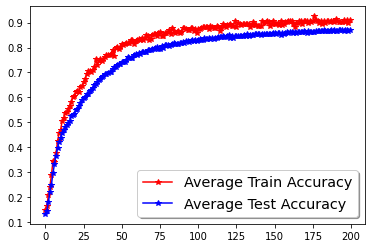

In [17]:
import matplotlib.pyplot as plt

# Create plots with pre-defined labels.
fig, ax = plt.subplots()
ax.plot(range(n_epochs), acc_train, 'r-*', label='Average Train Accuracy')
ax.plot(range(n_epochs), acc_test, 'b-*', label='Average Test Accuracy')

legend = ax.legend(loc='lower right', shadow=True, fontsize='x-large')

plt.show()

In [18]:
np.save('acc_train_miniSGD', acc_train)
np.save('acc_test_miniSGD', acc_test)
np.save('loss_miniSGD', total_loss/no_users)

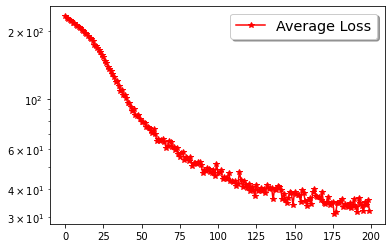

In [19]:
# Create plots with pre-defined labels.
fig, ax = plt.subplots()
ax.plot(range(n_epochs), total_loss/no_users, 'r-*', label='Average Loss')

legend = ax.legend(loc='upper right', shadow=True, fontsize='x-large')

plt.yscale('log')
plt.show()